## Import Library

- tensorflow 2.x(tf.keras)
- pandas
- numpy
- datetime
- matplotlib.pyplot
- google.colab
- os

In [1]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam

import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

import os

print(tf.__version__)

2.3.0


## Google Colab Mount

- account : leeyeoreum01@gmail.com

In [2]:
from google.colab import drive

drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


## Google Colab Working Directory Select

- csv file dir = 'tensorflow_2.x_working_dir'
- ipynb file dir = 'Colab Notebooks'

In [4]:
working_dir = 'digit_recognizer_data'

colab_default_dir = '/content/gdrive/My Drive/Colab Notebooks/my_own_program/AI program/'

github_local_repo = '/content/gdrive/My Drive/Colab Notebooks/my_own_program/'

original_dir = os.getcwd()

try:

    os.chdir(colab_default_dir + '/data/')

    if not os.path.exists(working_dir):
        os.mkdir(working_dir)

    os.chdir(working_dir)

    print('current_dir = ', os.getcwd())

except Exception as err:

    os.chdir(original_dir)
    print(str(err))

current_dir =  /content/gdrive/My Drive/Colab Notebooks/my_own_program/AI program/data/digit_recognizer_data


## CSV File Data Upload

- digit_train.csv
- digit_test.csv

In [5]:
try:

    original_train_df = pd.read_csv('digit_train_v2.csv')
    original_test_df = pd.read_csv('digit_test.csv')

    print('type(original_train_df) = ', type(original_train_df))
    print('original_train_df.shape = ', original_train_df.shape)
    print()
    print('type(original_test_df) = ', type(original_test_df))
    print('original_test_df.shape = ', original_test_df.shape)

    train_df = original_train_df.copy()
    test_df = original_test_df.copy()
    
except Exception as err:
    
    print(str(err))

type(original_train_df) =  <class 'pandas.core.frame.DataFrame'>
original_train_df.shape =  (41963, 785)

type(original_test_df) =  <class 'pandas.core.frame.DataFrame'>
original_test_df.shape =  (28000, 784)


## Data Generation

- train data : 70%
- test data : 30%

- Normalization (+ test data (<- test df)): True

In [6]:
class DataGeneration:
    
    # target_position = 0 (첫번째열이 정답데이터), target_position=-1 (마지막열이 정답데이터)
    def __init__(self, file, seperation_rate, target_position=-1):
        
        self.file = file
        
        self.seperation_rate = seperation_rate
        
        if (target_position == -1  or  target_position == 0):      
            self.target_position = target_position
        
        else:
            err_str = 'target_position must be -1 or 0'            
            raise Exception(err_str)    
            
    
    # print data target distribution 
    # str_of_kind : 'original data' or  'training data'  or  'test data'
    def __display_target_distribution(self, data, str_of_kind='original data'):
        
        print('=======================================================================================================')
        
        target_data = data[ :, self.target_position ]
        
        # numpy.unique() 사용하여 loaded data target 분포 확인
        unique, counts = np.unique(target_data, return_counts=True)

        unique_target = []
    
        for index in range(len(unique)):
        
            print('[DataGeneration] unique number of ' + str_of_kind + ' = ', unique[index], 
                  ', count = ', counts[index], ', ratio = ', np.round(100 * counts[index] / (target_data.shape[0]), 2), ' %')
        
            unique_target.append(unique[index])
    
        print('=======================================================================================================')
        
        
    # numpy.random.shuffle()  이용하여 training_data / test_data 생성
    def generate(self):
    
        # 데이터 불러오기, 파일이 없는 경우 exception 발생

        loaded_data = self.file

        print("[DataGeneration]  loaded_data.shape = ", loaded_data.shape)
            
        # print the target distribution of original data 
        
        self.__display_target_distribution(loaded_data, 'original data')
        
        
        # 분리비율에 맞게 테스트데이터로 분리
        total_data_num = len(loaded_data)
        test_data_num = int(len(loaded_data) * self.seperation_rate)

        # numpy.random.shuffle 을 이용하여 랜덤하게 데이터 섞기
        np.random.shuffle(loaded_data)
        
        # test_data 는 0 : test_data_num
        
        
        test_data = loaded_data[ 0:test_data_num ]

        # training_data 는 test_data_num 부터 끝까지 
        training_data = loaded_data[ test_data_num: ]

        # display target distribution of generated data 
        
        self.__display_target_distribution(training_data, 'training data')
        
        self.__display_target_distribution(test_data, 'test data')
        
        return training_data, test_data

In [7]:
# DataGeneration class 이용하여 training data , validation data, test data 생성

train_data = np.array(train_df) # 학습 데이터프레임

data_obj = DataGeneration(train_data, seperation_rate=0.3, target_position=0)
(train_train_data, train_test_data) = data_obj.generate()

test_data = np.array(test_df) # 예측 데이터프레임

print("train_data.shape = ", train_data.shape,
      ", train_data.ndim = ", train_data.ndim)
print("train_train_data.shape = ", train_train_data.shape, 
      ", train_test_data.shape = ", train_test_data.shape)
print("test_data.shape = ", test_data.shape,
      ", test_data.ndim = ", test_data.ndim)

[DataGeneration]  loaded_data.shape =  (41963, 785)
[DataGeneration] unique number of original data =  0 , count =  4128 , ratio =  9.84  %
[DataGeneration] unique number of original data =  1 , count =  4680 , ratio =  11.15  %
[DataGeneration] unique number of original data =  2 , count =  4175 , ratio =  9.95  %
[DataGeneration] unique number of original data =  3 , count =  4350 , ratio =  10.37  %
[DataGeneration] unique number of original data =  4 , count =  4067 , ratio =  9.69  %
[DataGeneration] unique number of original data =  5 , count =  3791 , ratio =  9.03  %
[DataGeneration] unique number of original data =  6 , count =  4136 , ratio =  9.86  %
[DataGeneration] unique number of original data =  7 , count =  4399 , ratio =  10.48  %
[DataGeneration] unique number of original data =  8 , count =  4057 , ratio =  9.67  %
[DataGeneration] unique number of original data =  9 , count =  4180 , ratio =  9.96  %
[DataGeneration] unique number of training data =  0 , count =  2

In [8]:
train_train_xdata = train_train_data[ :  , 1:]
train_train_tdata = train_train_data[ :  , [0]]

train_test_xdata = train_test_data[ :  , 1:]
train_test_tdata = train_test_data[ :  , [0]]

print("train_train_xdata = ", train_train_xdata.shape, 
      ", train_train_tdata = ", train_train_tdata.shape)
print("train_test_xdata = ", train_test_xdata.shape, 
      ", train_test_tdata = ", train_test_tdata.shape)

train_train_xdata =  (29375, 784) , train_train_tdata =  (29375, 1)
train_test_xdata =  (12588, 784) , train_test_tdata =  (12588, 1)


In [9]:
# 정규화(Normalization) 코드

def data_normalization(data):
  
    try:

        if data.ndim != 2:
            raise Exception("Warning: input data must be 2 dim!!")

        data = (data - np.min(data)) / (np.max(data) - np.min(data))

        return data

    except Exception as err:
        raise Exception

try:
    train_train_xdata = data_normalization(train_train_xdata)
    train_test_xdata = data_normalization(train_test_xdata)
    test_data = data_normalization(test_data)

except Exception as err:
    print(str(err))


In [10]:
print('max(train_train_xdata) = ', np.max(train_train_xdata))
print('min(train_train_xdata) = ', np.min(train_train_xdata))
print()

print('max(train_test_xdata) = ', np.max(train_test_xdata))
print('min(train_test_xdata) = ', np.min(train_test_xdata))
print()

print('max(test_data) = ', np.max(test_data))
print('min(test_data) = ', np.min(test_data))

max(train_train_xdata) =  1.0
min(train_train_xdata) =  0.0

max(train_test_xdata) =  1.0
min(train_test_xdata) =  0.0

max(test_data) =  1.0
min(test_data) =  0.0


## Get Dataframe

- function of getting dataframe before encoding csv

In [11]:
def get_dataframe(result):

    if result.ndim != 1:
        result = result.reshape(-1) # changing data shape to 1 dim in order to get df

    df = pd.DataFrame({
        'ImageId': np.array(range(1, (len(result)+1))),
        'Label': result
        })

    return df

## Beta Model

In [12]:
model = Sequential()

model.add(Conv2D(input_shape=(28, 28, 1),
                 kernel_size=3, filters=32,
                 strides=(1, 1), activation='relu', use_bias=True, padding='SAME'))

model.add(Conv2D(input_shape=(28, 28, 1),
                 kernel_size=3, filters=64,
                 strides=(1, 1), activation='relu', use_bias=True, padding='SAME'))

model.add(MaxPool2D(pool_size=(2, 2), padding='SAME'))

model.add(Conv2D(input_shape=(28, 28, 1),
                 kernel_size=3, filters=128,
                 strides=(1, 1), activation='relu', use_bias=True, padding='SAME'))

model.add(Conv2D(input_shape=(28, 28, 1),
                 kernel_size=3, filters=256,
                 strides=(1, 1), activation='relu', use_bias=True, padding='SAME'))

model.add(MaxPool2D(pool_size=(2, 2), padding='SAME'))

model.add(Conv2D(input_shape=(28, 28, 1),
                 kernel_size=3, filters=512,
                 strides=(1, 1), activation='relu', use_bias=True, padding='SAME'))


model.add(Conv2D(input_shape=(28, 28, 1),
                 kernel_size=3, filters=1024,
                 strides=(1, 1), activation='relu', use_bias=True, padding='SAME'))

model.add(MaxPool2D(pool_size=(2, 2), padding='SAME'))

model.add(Flatten())

model.add(Dense(10, activation='softmax'))

In [13]:
model.compile(optimizer=Adam(lr=1e-4),
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 256)       295168    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 512)         1

In [14]:
start_time = datetime.now()

hist = model.fit(train_train_xdata.reshape(-1, 28, 28, 1), train_train_tdata,
                 batch_size=50, epochs=50, validation_split=0.1)

end_time = datetime.now()

print('\nElasped time : ', end_time - start_time)

Epoch 1/50
529/529 [==============================] - 14s 26ms/step - loss: 0.2887 - accuracy: 0.9087 - val_loss: 0.1206 - val_accuracy: 0.9602
Epoch 2/50
529/529 [==============================] - 13s 25ms/step - loss: 0.0657 - accuracy: 0.9787 - val_loss: 0.0973 - val_accuracy: 0.9683
Epoch 3/50
529/529 [==============================] - 14s 26ms/step - loss: 0.0433 - accuracy: 0.9861 - val_loss: 0.0538 - val_accuracy: 0.9854
Epoch 4/50
529/529 [==============================] - 14s 26ms/step - loss: 0.0321 - accuracy: 0.9894 - val_loss: 0.0462 - val_accuracy: 0.9864
Epoch 5/50
529/529 [==============================] - 13s 25ms/step - loss: 0.0237 - accuracy: 0.9922 - val_loss: 0.0356 - val_accuracy: 0.9891
Epoch 6/50
529/529 [==============================] - 13s 25ms/step - loss: 0.0186 - accuracy: 0.9940 - val_loss: 0.0427 - val_accuracy: 0.9874
Epoch 7/50
529/529 [==============================] - 13s 25ms/step - loss: 0.0166 - accuracy: 0.9946 - val_loss: 0.0626 - val_accuracy:

In [15]:
model.evaluate(train_test_xdata.reshape(-1, 28, 28, 1), train_test_tdata)

394/394 [==============================] - 2s 6ms/step - loss: 0.0768 - accuracy: 0.9917


[0.07675588130950928, 0.9916587471961975]

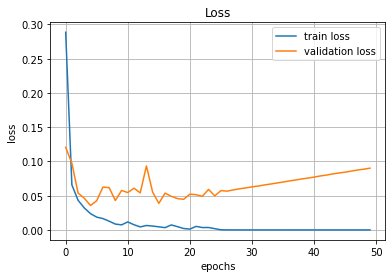

In [16]:
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid()

plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='validation loss')

plt.legend(loc='best')

plt.show()

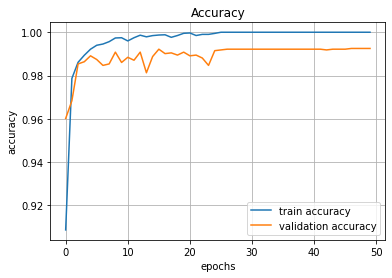

In [17]:
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid()

plt.plot(hist.history['accuracy'], label='train accuracy')
plt.plot(hist.history['val_accuracy'], label='validation accuracy')

plt.legend(loc='best')

plt.show()

## Processing Contaminated Data

- extracting contaminated data from train_train_xdata
- deleting extracted contaminated data in original_xdata
- debuging deleted data

In [18]:
real_predict_list = model.predict(train_train_xdata.reshape(-1, 28, 28, 1))

print('type(real_predict_list) = ', type(real_predict_list))
print()

logical_predict_list = np.argmax(real_predict_list, axis=1)

print("logical_predict_list sample = ", logical_predict_list[:10])
print()

label_list = train_train_tdata.flatten()

index_label_prediction_list = [[idx, label_list[idx], prediction] for idx, prediction in enumerate(logical_predict_list) if label_list[idx] != prediction]

print(index_label_prediction_list)

train_accuracy = 1 - (len(index_label_prediction_list) / len(label_list))

print('\ntrain accuracy = ', train_accuracy)

type(real_predict_list) =  <class 'numpy.ndarray'>

logical_predict_list sample =  [3 4 9 1 3 3 1 6 5 5]

[[26723, 1, 8], [26784, 8, 1], [26790, 3, 5], [26996, 8, 0], [27048, 3, 9], [27249, 8, 5], [27454, 5, 8], [27630, 9, 7], [27665, 6, 0], [27724, 3, 2], [27774, 3, 2], [27854, 1, 3], [28060, 9, 4], [28111, 5, 9], [28165, 9, 4], [28239, 9, 5], [28350, 5, 8], [28540, 5, 9], [28955, 3, 9], [29017, 3, 2], [29067, 3, 2], [29152, 8, 5]]

train accuracy =  0.9992510638297872


len(index_label_prediction_list) =  22



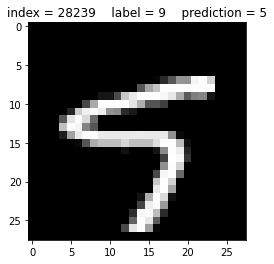

In [19]:
print("len(index_label_prediction_list) = ", len(index_label_prediction_list))
print()

random_pick_index = np.random.randint(len(index_label_prediction_list))

false_data_index = index_label_prediction_list[random_pick_index][0]
false_data_label = index_label_prediction_list[random_pick_index][1]
false_data_prediction = index_label_prediction_list[random_pick_index][2]

img = train_train_xdata[false_data_index].reshape(28, 28)

title = 'index = ' + str(false_data_index) + '    ' + 'label = ' + str(false_data_label) + '    ' + 'prediction = ' + str(false_data_prediction)

plt.title(title)
plt.imshow(img, cmap='gray')
plt.show()

len(index_label_prediction_list) =  22

start index : 0
count : 22


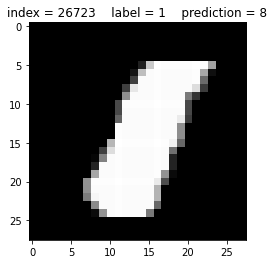

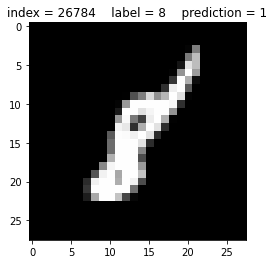

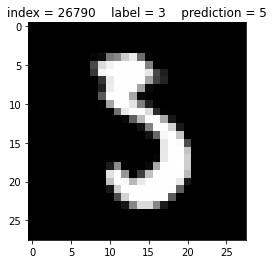

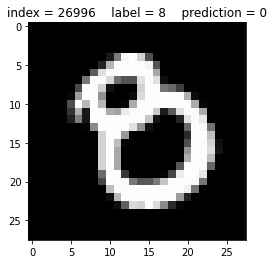

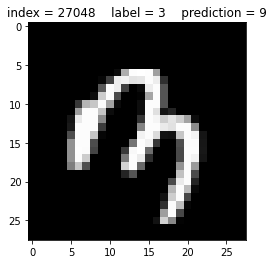

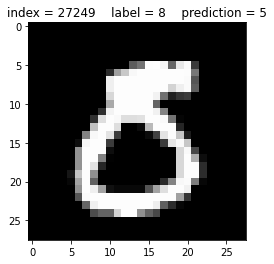

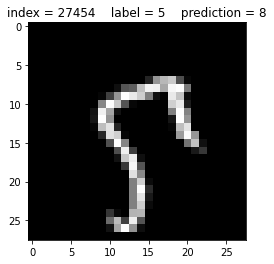

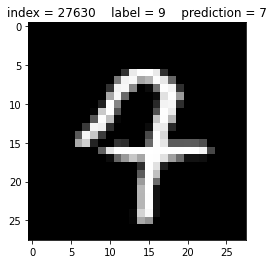

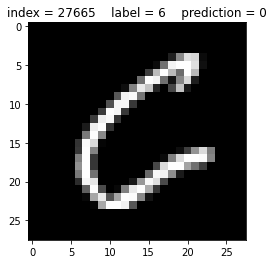

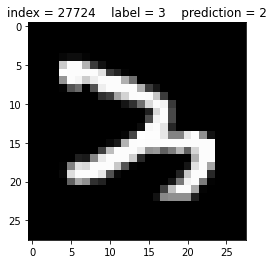

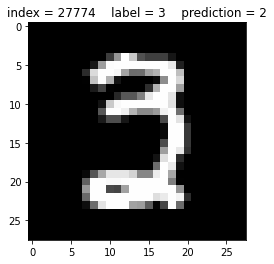

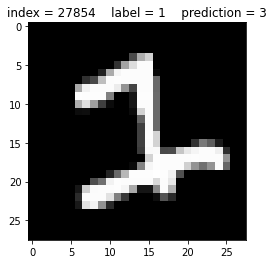

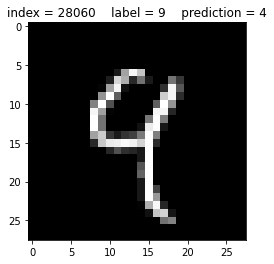

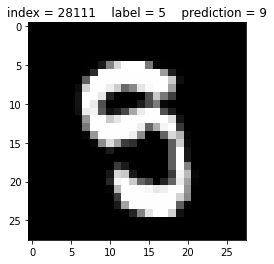

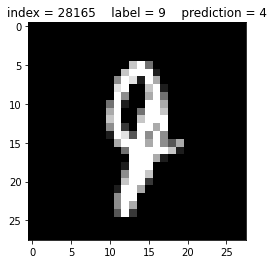

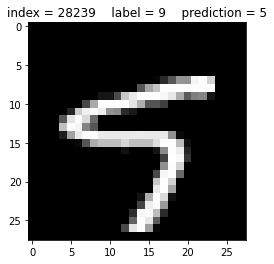

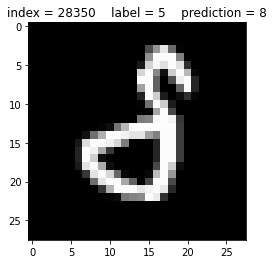

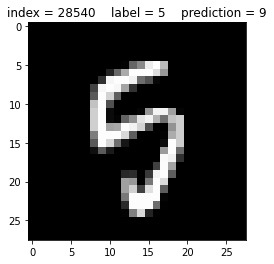

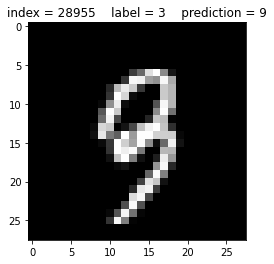

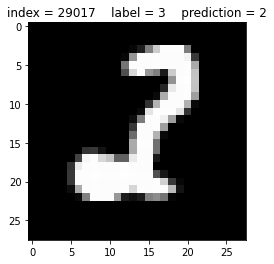

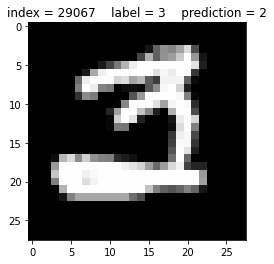

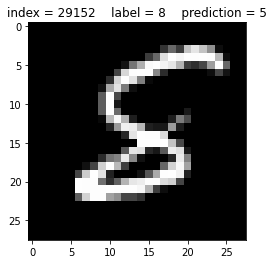

In [20]:
print("len(index_label_prediction_list) = ", len(index_label_prediction_list))
print()

start_index = int(input("start index : "))
count = int(input("count : "))
end_index = start_index + count

for self_pick_index in range(start_index, end_index):

    false_data_index = index_label_prediction_list[self_pick_index][0]
    false_data_label = index_label_prediction_list[self_pick_index][1]
    false_data_prediction = index_label_prediction_list[self_pick_index][2]

    img = train_train_xdata[false_data_index].reshape(28, 28)

    title = 'index = ' + str(false_data_index) + '    ' + 'label = ' + str(false_data_label) + '    ' + 'prediction = ' + str(false_data_prediction)

    plt.title(title)
    plt.imshow(img, cmap='gray')
    plt.show()

In [21]:

contaminated_index_list = [
                            27630, 27665, 27774, 28060, 28239,
                            28350, 29017, 
                          ]


In [22]:
original_xdata_list = data_normalization(np.array(original_train_df)[ :  , 1: ])

contaminated_data_list = [train_train_xdata[cont_idx] for cont_idx in contaminated_index_list]

ori_cont_idx_list = []

for cont_data in contaminated_data_list:
    
    for ori_idx, ori_xdata in enumerate(original_xdata_list):

        if np.array_equal(cont_data, ori_xdata):

            ori_cont_idx_list.append(ori_idx)

print('len(contaminated_index_list) = ', len(contaminated_index_list))
print('len(ori_cont_idx_list) = ', len(ori_cont_idx_list))

len(contaminated_index_list) =  7
len(ori_cont_idx_list) =  7


len(contaminated_data) =  7
type(check_data_list) =  <class 'numpy.ndarray'>
len(check_data_list) =  7

check_data_list sample =  [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

type(logical_review_prediction_list) =  <class 'numpy.ndarray'>
len(logical_review_prediction_list) =  7
logical_review_prediction_list sample =  [7 0 2 4 5]

new_prediction_list sample =  [[36541, 9, 7], [31623, 6, 0], [25082, 3, 2], [40251, 9, 4], [12513, 9, 5]]

start index : 0
count : 7



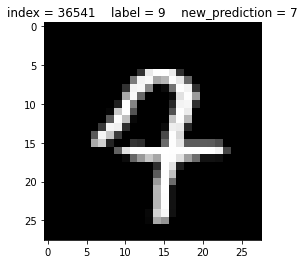

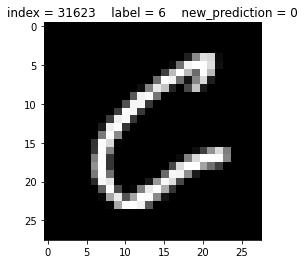

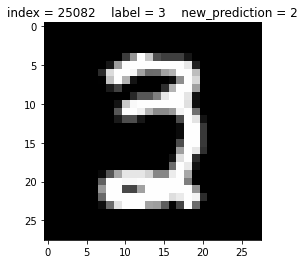

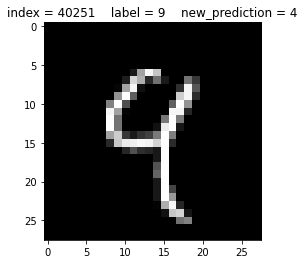

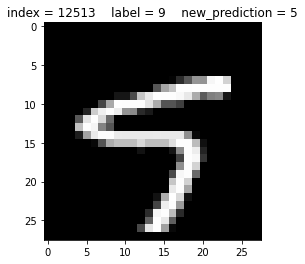

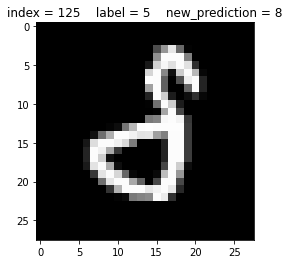

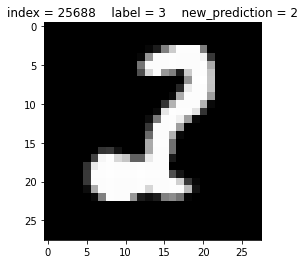

In [23]:
# checking for labeled contaminated data

original_data = np.array(original_train_df)

original_xdata = original_data[ :  , 1: ]
original_tdata = original_data[ :  , [0]]

check_data_list = np.array([original_xdata[check_index] for check_index in ori_cont_idx_list])
check_data_label_list = np.array([original_tdata[check_index] for check_index in ori_cont_idx_list]).flatten()

print("len(contaminated_data) = ", len(ori_cont_idx_list))
print("type(check_data_list) = ", type(check_data_list))
print("len(check_data_list) = ", len(check_data_list))
print()

print("check_data_list sample = ", check_data_list[:3])
print()

real_review_prediction_list = model.predict(check_data_list.reshape(-1, 28, 28, 1))
logical_review_prediction_list = np.argmax(real_review_prediction_list, axis=1)

print("type(logical_review_prediction_list) = ", type(logical_review_prediction_list))
print("len(logical_review_prediction_list) = ", len(logical_review_prediction_list))
print("logical_review_prediction_list sample = ", logical_review_prediction_list[:5])
print()

new_prediction_list = [[ori_cont_idx_list[idx], check_data_label_list[idx], val] for idx, val in enumerate(logical_review_prediction_list)]

print("new_prediction_list sample = ", new_prediction_list[:5])
print()

start_index = int(input("start index : "))
count = int(input("count : "))
end_index = start_index + count
print()

for cont_data_index in range(start_index, end_index):

    original_data_index = new_prediction_list[cont_data_index][0]
    original_data_label = new_prediction_list[cont_data_index][1]
    original_data_new_prediction = new_prediction_list[cont_data_index][2]

    img = original_xdata[original_data_index].reshape(28, 28)

    title = 'index = ' + str(original_data_index) + '    ' + 'label = ' + str(original_data_label) + '    ' + 'new_prediction = ' + str(original_data_new_prediction)

    plt.title(title)
    plt.imshow(img, cmap='gray')
    plt.show()

## File Generation

- new version of 'digit_train.csv'
- new version of 'digit_submission.csv'

In [24]:
new_original_train_df = original_train_df.copy()

print('type(new_original_train_df) = ', type(new_original_train_df))
print('before droping new_original_train_df.shape = ', new_original_train_df.shape)
print()

new_original_train_df.drop(new_original_train_df.index[ori_cont_idx_list], inplace=True)

print('after droping new_original_train_df.shape = ', new_original_train_df.shape)

new_original_train_df.to_csv('digit_train_v2.csv', index=False)

type(new_original_train_df) =  <class 'pandas.core.frame.DataFrame'>
before droping new_original_train_df.shape =  (41963, 785)

after droping new_original_train_df.shape =  (41956, 785)


In [25]:
print('current directory : ', os.getcwd())
print()

os.chdir(colab_default_dir)
os.chdir('./digit_recognizer_submission/')

print('moved directory : ', os.getcwd())

predicted_num = model.predict(test_data.reshape(-1, 28, 28, 1))

result = np.argmax(predicted_num, axis=1)

model_submission = get_dataframe(result)

model_submission.to_csv('digit_submission.csv', index=False)

current directory :  /content/gdrive/My Drive/Colab Notebooks/my_own_program/AI program/data/digit_recognizer_data

moved directory :  /content/gdrive/My Drive/Colab Notebooks/my_own_program/AI program/digit_recognizer_submission


## Kaggle Submit

In [26]:
print("current directory : ", os.getcwd())

current directory :  /content/gdrive/My Drive/Colab Notebooks/my_own_program/AI program/digit_recognizer_submission


In [27]:
ls -1ha kaggle.json

kaggle.json


In [29]:
# checking kaggle.json

'''
from google.colab import files
files.upload()
'''

'\nfrom google.colab import files\nfiles.upload()\n'

In [30]:

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json
# 본인이 참가한 모든 대회 보기 
!kaggle competitions list


ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                   2030-07-01 23:59:00  Getting Started     Prizes        272           False  
gan-getting-started                            2030-07-01 23:59:00  Getting Started     Prizes        110           False  
tpu-getting-started                            2030-06-03 23:59:00  Getting Started  Knowledge        360           False  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       2400            True  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      18397            True  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge       4653           False  
connectx

In [31]:
!kaggle competitions submit -c digit-recognizer -f digit_submission.csv -m "accuracy = 99.17% (test)"

100% 208k/208k [00:03<00:00, 68.2kB/s]
Successfully submitted to Digit Recognizer

## Github Upload

In [33]:
os.chdir(github_local_repo)

os.getcwd()

'/content/gdrive/My Drive/Colab Notebooks/my_own_program'

In [34]:
!git config --global user.email "leeyeoreum01@gmail.com"
!git config --global user.name "leeyeoreum02"

In [35]:
!git pull origin master

From https://github.com/leeyeoreum02/my_own_program
 * branch            master     -> FETCH_HEAD
Already up to date.


In [36]:
!git add .

In [37]:
!git status

On branch master
Changes to be committed:
  (use "git reset HEAD <file>..." to unstage)

	modified:   AI program/data/digit_recognizer_data/digit_train_v2.csv
	modified:   AI program/digit_recognizer(tf_2.x).ipynb
	modified:   AI program/digit_recognizer_submission/digit_submission.csv



In [38]:
!git commit -m "9/19 processing kaggle submit socre"

[master 3a82407] 9/19 processing contaminated data v2
 3 files changed, 28002 insertions(+), 28012 deletions(-)
 rewrite AI program/digit_recognizer(tf_2.x).ipynb (94%)
 rewrite AI program/digit_recognizer_submission/digit_submission.csv (74%)


In [39]:
!git push origin master

Counting objects: 9, done.
Delta compression using up to 2 threads.
Compressing objects: 100% (9/9), done.
Writing objects: 100% (9/9), 265.22 KiB | 6.80 MiB/s, done.
Total 9 (delta 4), reused 0 (delta 0)
remote: Resolving deltas: 100% (4/4), completed with 4 local objects.
remote: warning: GH001: Large files detected. You may want to try Git Large File Storage - https://git-lfs.github.com.
remote: warning: See http://git.io/iEPt8g for more information.
remote: warning: File AI program/data/digit_recognizer_data/digit_train_v2.csv is 73.13 MB; this is larger than GitHub's recommended maximum file size of 50.00 MB
To https://github.com/leeyeoreum02/my_own_program.git
   38d649e..3a82407  master -> master
